# Predict fuel efficiency using Simple Linear Regression with Neural Network Model
We are going to make use of modules and functions from the Keras API to train a linear regression model to predict fuel efficiency from features such as `cylinders, displacement, horsepower`, and `weight`. We shall train both shallow and deep neural network models and compare them.

## Dataset
We will use the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset and demonstrates how to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles. The dataset is also available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).

## Import required packages

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import scipy.stats as stats 
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

### Get the data

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

print(f'Shape (rows, cols): {raw_dataset.shape}')
raw_dataset.head()

Shape (rows, cols): (398, 8)


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


### Check for columns with missing data

In [3]:
z = raw_dataset.isnull().sum()
print(f'Columns with missing data:\n{z[z > 0]}')

Columns with missing data:
Horsepower    6
dtype: int64


### Handling missing values
The dataset contains a 6 missing values in the `Horsepower` feature. We can safely drop these rows from the dataset without missing too much information. 

In [4]:
dataset = raw_dataset.copy()
dataset = dataset.dropna()

### Check `dtypes` of the variables

In [5]:
dataset.dtypes

MPG             float64
Cylinders         int64
Displacement    float64
Horsepower      float64
Weight          float64
Acceleration    float64
Model Year        int64
Origin            int64
dtype: object

The `"Origin"` column ought to be categorical, not numeric. So the next step is to one-hot encode the values in the column with [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

In [6]:
dataset['Origin'].unique()

array([1, 3, 2], dtype=int64)

**Based on the information or metadata about the data, the numeric values map to the countries as follows: `1 --> 'USA', 2 --> 'Europe', 3 --> 'Japan'`.

In [7]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns = ['Origin'], prefix = '', prefix_sep = '', dtype = float)
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0.0,0.0,1.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,0.0,0.0,1.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,0.0,0.0,1.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,0.0,0.0,1.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,0.0,0.0,1.0


#### Note
Neglecting to specify a data type by way of a `dtype` argument in `pd.get_dummies` will output boolean values for the dummy variables. This will lead to errors during **normalization** when instantiating the Tensor object, if the feature values are not cast to a uniform type when passing the array into `tf.keras.layers.Normalization.adapt()`.  [Tensor objects](https://www.tensorflow.org/guide/tensor) must house uniform data types.

### Inspect the data
Let's check the relationship of some of the features/predictors with the target.

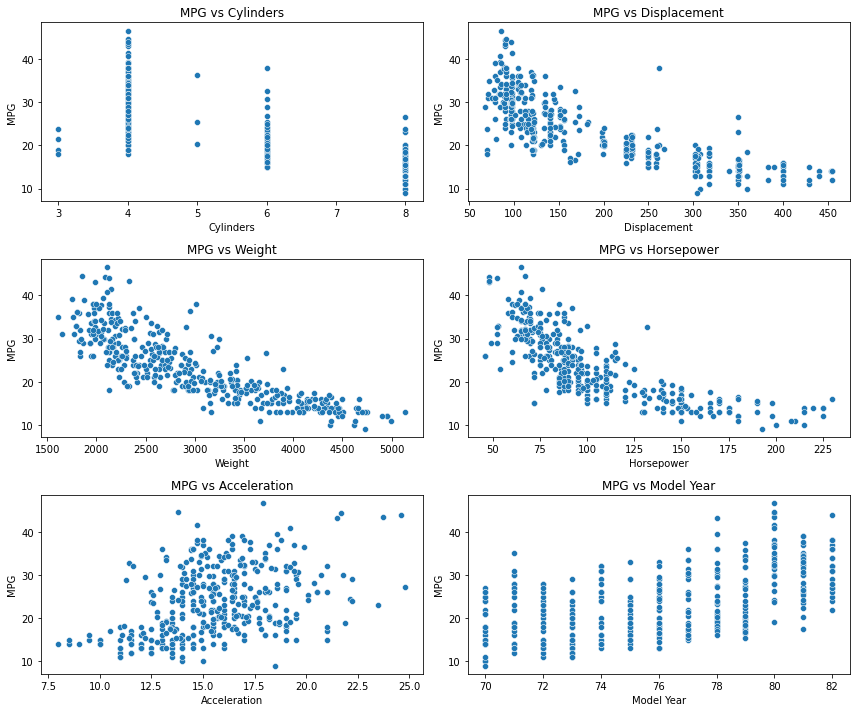

In [8]:
fig, ax = plt.subplots(3, 2, figsize=(12, 10))

sns.scatterplot(x = dataset['Cylinders'], y = dataset['MPG'], ax = ax[0,0])
ax[0,0].title.set_text('MPG vs Cylinders')

sns.scatterplot(x = dataset['Displacement'], y = dataset['MPG'], ax = ax[0,1])
ax[0,1].title.set_text('MPG vs Displacement')

sns.scatterplot(x = dataset['Horsepower'], y = dataset['MPG'], ax = ax[1,1])
ax[1,1].title.set_text('MPG vs Horsepower')

sns.scatterplot(x = dataset['Weight'], y = dataset['MPG'], ax = ax[1,0])
ax[1,0].title.set_text('MPG vs Weight')

sns.scatterplot(x = dataset['Acceleration'], y = dataset['MPG'], ax = ax[2,0])
ax[2,0].title.set_text('MPG vs Acceleration')

sns.scatterplot(x = dataset['Model Year'], y = dataset['MPG'], ax = ax[2,1])
ax[2,1].title.set_text('MPG vs Model Year')
plt.tight_layout();

### Some Observations
* The number of `Cylinders` and `Model Year` are discrete and do not show any clear correlation with the target variable ` MPG`
* `Displacement, Weight` and `Horsepower` show **negative** correlations with `MPG`, with clear signs of nonlinear relationship.
* `Accelaration` show a somewhat positive correlation with `MPG`.
### Get basic Info and statistics

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Europe        392 non-null    float64
 8   Japan         392 non-null    float64
 9   USA           392 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 33.7 KB


In [10]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
MPG,392.0,23.445918,7.805007,9.0,17.000,22.75,29.000,46.6
Cylinders,392.0,5.471939,1.705783,3.0,4.000,4.00,8.000,8.0
Displacement,392.0,194.411990,104.644004,68.0,105.000,151.00,275.750,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.000,93.50,126.000,230.0
Weight,392.0,2977.584184,849.402560,1613.0,2225.250,2803.50,3614.750,5140.0
Acceleration,392.0,15.541327,2.758864,8.0,13.775,15.50,17.025,24.8
Model Year,392.0,75.979592,3.683737,70.0,73.000,76.00,79.000,82.0
Europe,392.0,0.173469,0.379136,0.0,0.000,0.00,0.000,1.0
Japan,392.0,0.201531,0.401656,0.0,0.000,0.00,0.000,1.0
USA,392.0,0.625000,0.484742,0.0,0.000,1.00,1.000,1.0


## Checking the distribution of the target variable
For linear regression, the target variable must be normally distributed. We can check this using a **histogram** and **Q-Q plot**.

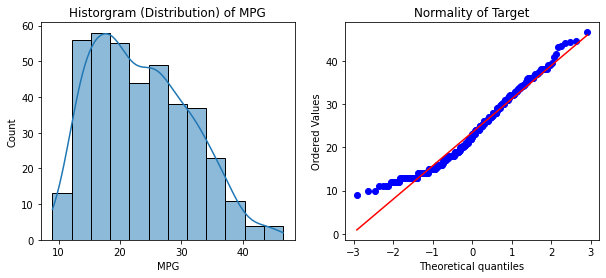

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(dataset['MPG'], kde = True, ax = ax[0])
ax[0].title.set_text('Historgram (Distribution) of MPG')
stats.probplot(dataset['MPG'], dist = 'norm', plot = ax[1])
ax[1].set_title('Normality of Target');

From the charts above, the target Miles per gallon (MPG) is not normally distributed. However, looking at both the histogram and the QQ-plot, and considering that we are dealing with a very small sample of cars (`392` observations), we can conclude that according to the **Central Limit Theorem**, with sufficiently large sample size, the distribution of MPG would approach normal or gaussian in nature. We will therefore continue with preparing the data for linear regression model.

## Split the data into training and test sets

In [12]:
X = dataset.drop('MPG', axis = 1)
y = dataset.loc[:, 'MPG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

## Normalize the features
From the basic statistics using `.describe` method, it can be seen that the features have different the ranges and spread.

In [13]:
dataset.describe().T[['mean', 'std']]

,mean,std
MPG,23.445918,7.805007
Cylinders,5.471939,1.705783
Displacement,194.411990,104.644004
Horsepower,104.469388,38.491160
Weight,2977.584184,849.402560
Acceleration,15.541327,2.758864
Model Year,75.979592,3.683737
Europe,0.173469,0.379136
Japan,0.201531,0.401656
USA,0.625000,0.484742


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Also some machine learning algorithms use distant metrics and a large number might falsely suggest that a feature is more than than one with a smaller value or at a further distant than another feature. Normalising the features helps aleviate this problem.

Although a model *might* converge without feature normalization, normalization makes training much more stable.

**Note:** There is no advantage to normalizing the **one-hot features** — it is done here for simplicity. For more details on how to use the preprocessing layers, refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial.

### The Normalization layer
The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

We will create the layer then fit the state of the preprocessing layer to the data by calling `Normalization.adapt`.

In [14]:
normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None)

In [15]:
normalizer.adapt(np.array(X_train['Horsepower']))

## Simple Linear regression (with one predictor)
We will build a single-variable linear regression model to predict `'MPG'` from `'Horsepower'`. We could instead use `Weight, Displacement` or `Acceleration` as the single predictor.

### Build the shallow neural network model
We will create a two-step Keras Sequential model with the first layer being `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) we defined above and adapted to the whole dataset.

In [16]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

### Compile and Train the Model
In compiling the model we'll provide the loss function to be optimzed and an **optimizer** with a **learning rate**.
* Configure the model with Keras `Model.compile` and train with `Model.fit` for `100` epochs.

In [17]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss = 'mean_absolute_error')

In [18]:
%%time
epochs=100
history = linear_model.fit(
    X_train['Horsepower'],
    y_train,
    epochs = epochs,
    verbose = 0,
    validation_split = 0.2)

CPU times: total: 1.27 s
Wall time: 4.18 s


## Visualize the performance of the model
### Helper function to visualize model performance

In [19]:
def plot_loss(history):
    plt.figure(figsize = (8, 5))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('MAE in [MPG]')
    plt.legend()
    plt.grid(True)

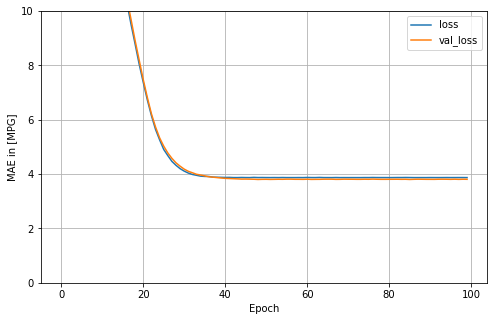

In [20]:
plot_loss(history)

### Visualize the results
Since this is a single variable regression, it's easy to view the model's predictions as a function of the input.

In [21]:
x = tf.constant(np.linspace(0.0, 250, 251))
y = linear_model.predict(x)

8/8 [==============================] - 0s 2ms/step


In [22]:
def plot_horsepower(x, y):
    plt.figure(figsize = (8, 5))
    plt.scatter(X_train['Horsepower'], y_train, label='Data')
    plt.plot(x, y, color='red', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

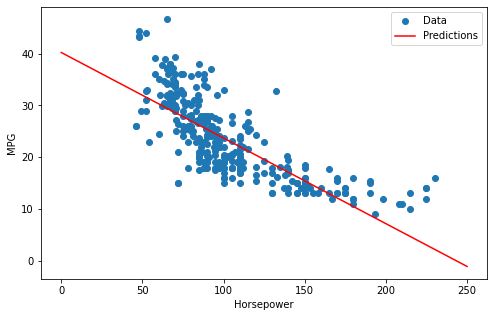

In [23]:
plot_horsepower(x, y)

### Prediction using the test dataset
We will save the results on the test set for later comparison with deep neural network model.

In [24]:
test_results = {}

In [25]:
test_results['linear_model'] = linear_model.evaluate(X_test['Horsepower'], y_test, verbose = 0)

### Regression with a deep neural network (DNN)
We will implement a single-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with `normalizer` for a multiple-input model).
* Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense` single-output layer.

### A Helper function to build and compile model

In [26]:
def build_and_compile_model(normalizer):
    model = keras.Sequential([
      normalizer,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
    return model

## Build and Train the DNN Model

In [27]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                128       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [28]:
%%time
epochs = 100
history = dnn_model.fit(
    X_train['Horsepower'],
    y_train,
    validation_split = 0.2,
    verbose = 0, epochs = epochs)

CPU times: total: 1.52 s
Wall time: 4.56 s


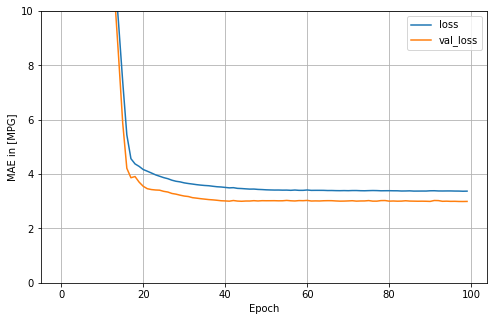

In [29]:
plot_loss(history)

Let's plot the predictions as a function of `'Horsepower'`, and notice how the power of including nonlinearity in the form of `ReLu` in the hidden layers.

In [30]:
x = tf.constant(np.linspace(0.0, 250, 251))
y = dnn_model.predict(x)

8/8 [==============================] - 0s 2ms/step


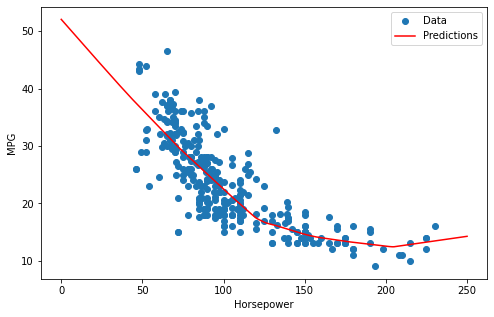

In [31]:
plot_horsepower(x, y)

In [32]:
test_results['dnn_model'] = dnn_model.evaluate(X_test['Horsepower'], y_test, verbose = 0)

### Compare Performance between shallow and deep Neural Network Models

In [33]:
pd.DataFrame(test_results, index = ['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,3.641546
dnn_model,3.105154


The deep neural network clearly out performed the shallow neural network in terms of `Mean Absolute Error (MAE)`. It can also be observed in the chart above that the model captures the nonlinear nature of the relationship between `MPG` and `Horsepower` better than the shallow network does.

Note that running this model multiple time will give different results. To obtain a reasonable estimate of the model's performance, **cross validation** technique is used.

### Make predictions
Let's make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

3/3 [==============================] - 0s 2ms/step


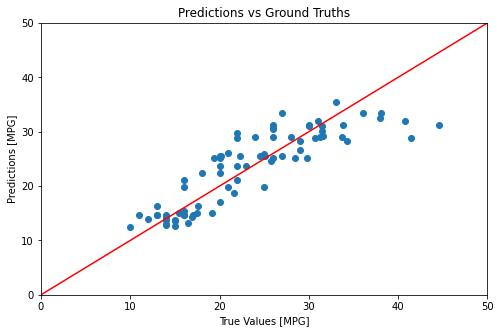

In [34]:
y_preds = dnn_model.predict(np.array(X_test['Horsepower']))

plt.figure(figsize = (8, 5))
plt.scatter(y_test, y_preds)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.title('Predictions vs Ground Truths')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims, c = 'red');

### Residuals or Error Distribution
The deep neural Network model appears doing a reasonably good job. Let's check the error distribution.

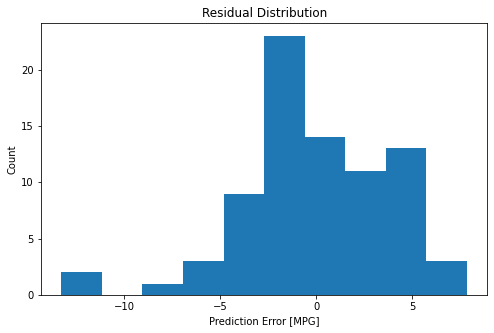

In [35]:
residuals = np.array(y_preds).flatten() - np.array(y_test)

plt.figure(figsize = (8, 5))
plt.hist(residuals)
plt.xlabel('Prediction Error [MPG]')
plt.title('Residual Distribution')
plt.ylabel('Count');

One of the assumptions for linear regression is that **Residuals are normally distributed**. This assumption is not met and the **Confidence intervals** will likely be affected. 

The histogram shows hint that collecting more car observations could lead to this assumption being met. Another remedy could be to to performing **nonlinear transformations** on variables.

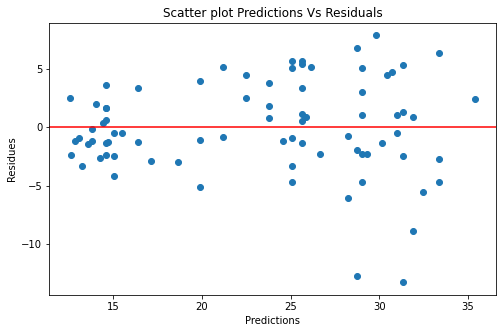

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.scatter(y_preds, residuals)
plt.axhline(c = 'red')
ax.set_title('Scatter plot Predictions Vs Residuals')
ax.set_xlabel('Predictions')
ax.set_ylabel('Residues');

The scatter plot above shows that we are having almost ***“having the same scatter.”*** above and below `Residues = 0` line, though not perfectly so. Again, it indicates that with sufficiently large dataset, heteroscedasticity won't be an issue for this model.
Heteroscedasticity can be solved either by using **weighted least squares regression instead of the standard OLS** or **transforming either the dependent or highly skewed variables**. Performing a log transformation on the dependent variable is not a bad place to start.